In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import requests
from tqdm import tqdm
import os
import zipfile
import json
from pycocotools.coco import COCO
from PIL import Image

In [5]:
# 2. Load annotations 
with open('annotations/instances_train2017.json') as f:
    train_annotations = json.load(f)
with open('annotations/captions_train2017.json') as f:
    caption_annotations = json.load(f)

# 3. Create a mapping of image_id to captions
image_id_to_captions = {}
for ann in caption_annotations['annotations']:
    image_id = ann['image_id']
    caption = ann['caption']
    if image_id not in image_id_to_captions:
        image_id_to_captions[image_id] = []
    image_id_to_captions[image_id].append(caption)

# 4. Use pycocotools for convenient filtering
coco = COCO('annotations/instances_train2017.json')
catIds = coco.getCatIds(catNms=['dog'])
imgIds = coco.getImgIds(catIds=catIds) 
images = coco.loadImgs(imgIds)

# 5. Extract dog images
image_dir = 'train2017'
output_dir = 'dog_images'
os.makedirs(output_dir, exist_ok=True)

for img in images:
    try:
        filename = img['file_name']
        img_path = os.path.join(image_dir, filename)
        img = Image.open(img_path)
        img.save(os.path.join(output_dir, filename))
        print(f"Saved: {filename}")
    except Exception as e:
        print(f"Error processing {filename}: {e}")

loading annotations into memory...
Done (t=9.48s)
creating index...
index created!
Saved: 000000098304.jpg
Saved: 000000204800.jpg
Saved: 000000524291.jpg
Saved: 000000311301.jpg
Saved: 000000491525.jpg
Saved: 000000147471.jpg
Saved: 000000131087.jpg
Saved: 000000278550.jpg
Saved: 000000581654.jpg
Saved: 000000253981.jpg
Saved: 000000450590.jpg
Saved: 000000106525.jpg
Saved: 000000368676.jpg
Saved: 000000253988.jpg
Saved: 000000491556.jpg
Saved: 000000000042.jpg
Saved: 000000385066.jpg
Saved: 000000229419.jpg
Saved: 000000499760.jpg
Saved: 000000106545.jpg
Saved: 000000516146.jpg
Saved: 000000548912.jpg
Saved: 000000417846.jpg
Saved: 000000122934.jpg
Saved: 000000294968.jpg
Saved: 000000090173.jpg
Saved: 000000368702.jpg
Saved: 000000344127.jpg
Saved: 000000581704.jpg
Saved: 000000000074.jpg
Saved: 000000237643.jpg
Saved: 000000548946.jpg
Saved: 000000245842.jpg
Saved: 000000442450.jpg
Saved: 000000335955.jpg
Saved: 000000024664.jpg
Saved: 000000204889.jpg
Saved: 000000139355.jpg
Saved

In [6]:
from PIL import Image
import random

# 6. Prepare data for Hugging Face Dataset
data = []
for img in images:
    try:
        filename = img['file_name']
        img_id = img['id']
        img_path = os.path.join(image_dir, filename)

        # Get captions for this image
        captions = image_id_to_captions.get(img_id, [])
        if not captions:
            print(f"Warning: No captions found for {filename}")
            continue  # Skip images without captions

        data.append({
            'image': img_path,
            'captions': captions 
        })

    except Exception as e:
        print(f"Error processing {filename}: {e}")

print(len(data))

4385


In [7]:
import PIL.Image
from datasets import Dataset, Image
# Split data into train and test
random.shuffle(data)  # Shuffle the data for randomness
split_index = int(0.95 * len(data))
train_data = data[:split_index]
test_data = data[split_index:]

BATCH_SIZE = 32
#print("Required batches: ", (len(data)/BATCH_SIZE))

# 7. Create Hugging Face Datasets (batch by batch)
def load_images_in_batches(data, batch_size):
    all_images = []
    all_captions = []  # Store all captions
    batch_count = 0
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        for item in batch:
            image = PIL.Image.open(item['image']).convert('RGB').resize((336, 336))
            for caption in item['captions']:  # Iterate over captions
                all_images.append(image.copy())  # Copy the image for each caption
                all_captions.append(caption)

    return all_images, all_captions  # Return both images and captions

train_images, train_captions = load_images_in_batches(train_data, BATCH_SIZE)
train_dataset = Dataset.from_dict({
    'image': train_images,
    'captions': train_captions
})
print("Train dataset ready")

test_images, test_captions = load_images_in_batches(test_data, BATCH_SIZE)
test_dataset = Dataset.from_dict({
    'image': test_images,
    'captions': test_captions
})
print("Test dataset ready")

# Close all opened images after creating the datasets
for img in train_dataset['image'] + test_dataset['image']:
    img.close()

print("Images processed and ready to push to hub")

Train dataset ready
Test dataset ready
Images processed and ready to push to hub


In [11]:
print(train_dataset)

Dataset({
    features: ['image', 'captions'],
    num_rows: 20833
})


In [13]:
print(test_dataset)

Dataset({
    features: ['image', 'captions'],
    num_rows: 1100
})


In [15]:
import os

if not os.path.isdir("LLaVA"):
    !git clone https://github.com/haotian-liu/LLaVA
else:
    print("LLaVA directory already exists. Skipping clone.")

LLaVA directory already exists. Skipping clone.


In [17]:
import torch
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from PIL import Image
import transformers
from transformers import AutoProcessor, Trainer, TrainingArguments, BitsAndBytesConfig, HfArgumentParser, TrainingArguments, pipeline, logging
import torchvision.transforms as transforms

In [19]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model
import torch.nn as nn

#cuda_idx = 2 # edit device index that you want to track
#device = f'cuda:{cuda_idx}'

device = 'cuda'

model_path = "liuhaotian/llava-v1.6-mistral-7b"
#model_path = "liuhaotian/llava-v1.5-7b"
#model_path = "liuhaotian/llava-v1.6-vicuna-7b"

model_name = get_model_name_from_path(model_path)
print(model_name)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=model_name,
    cache_dir='',
    use_flash_attn=True,
    device=device,
    #load_8bit = #NOT SUPPORTED
    #load_4bit = #NOT SUPPORTED
)

llava-v1.6-mistral-7b


/home/respailab/anaconda3/envs/llava_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/respailab/anaconda3/envs/llava_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/respailab/anaconda3/envs/llava_env/lib/python3.10/site-packages/torch/nn/modules/module.py:2025: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is 

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
print(model)

LlavaMistralForCausalLM(
  (model): LlavaMistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralFlashAttention2(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): Mis

In [23]:
# Inference
import re
import torch
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image
import requests
from io import BytesIO

from llava.constants import (
    IMAGE_TOKEN_INDEX,
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    IMAGE_PLACEHOLDER,
)
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import (
    process_images,
    tokenizer_image_token,
    get_model_name_from_path,
)

In [25]:
# Common function to create prompts
def create_prompt (query, model, model_name=model_name, caption=None):
    image_token_se = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
    if IMAGE_PLACEHOLDER in query:
        if model.config.mm_use_im_start_end:
            query = re.sub(IMAGE_PLACEHOLDER, image_token_se, query)
        else:
            query = re.sub(IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN, query)
    else:
        if model.config.mm_use_im_start_end:
            query = image_token_se + "\n" + query
        else:
            query = DEFAULT_IMAGE_TOKEN + "\n" + query
            
    conv_mode = infer_conv_mode(model_name)
    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], query)
    if caption is not None:
        conv.append_message(conv.roles[1], caption)
    else:
        conv.append_message(conv.roles[1], None)
    return conv.get_prompt()

# Common function to infer conversation mode
def infer_conv_mode(model_name):
    if "llama-2" in model_name.lower():
        return "llava_llama_2"
    elif "mistral" in model_name.lower():
        return "mistral_instruct"
    elif "v1.6-34b" in model_name.lower():
        return "chatml_direct"
    elif "v1" in model_name.lower():
        return "llava_v1"
    elif "mpt" in model_name.lower():
        return "mpt"
    else:
        return "llava_v0"

In [27]:
import torch
import re
import PIL.Image

def load_image(image_input):
    # Check if the input is a string (path or URL)
    if isinstance(image_input, str):
        if image_input.startswith("http") or image_input.startswith("https"):
            response = requests.get(image_input)
            image = Image.open(BytesIO(response.content)).convert("RGB")
        else:
            image = Image.open(image_input).convert("RGB")
    elif isinstance(image_input, PIL.Image.Image):
        # Input is already an Image object, return as is
        image = image_input
    else:
        raise ValueError("Unsupported image input type")
    return image

# Common function to process images
def process_and_prepare_images(image_files, image_processor, model, device):
    images = [load_image(image_file) for image_file in image_files]
    images_tensor = process_images(
        images,
        image_processor,
        model.config
    ).to(
        device,
        dtype=torch.bfloat16
    )
    image_sizes = [image.size for image in images]
    return images_tensor, image_sizes

def eval_model(tokenizer, model, image_processor, context_len, image_file, query, model_name=model_name, sep=",", temperature=1.0, num_beams=1, max_new_tokens=512):
    # Model
    disable_torch_init()
    
    # Create prompt using the common function
    prompt = create_prompt(query, model, model_name)
    
    print(f"Prompt: {prompt}")
    
    # Process images using the common function
    if isinstance(image_file, list):
        images_tensor, image_sizes = process_and_prepare_images(image_file, image_processor, model, model.device)
    elif isinstance(image_file, str):
        images_tensor, image_sizes = process_and_prepare_images([image_file], image_processor, model, model.device)
    else:
        # If image_file is neither a list nor a string, it's likely an Image object or similar; wrap it in a list
        images = [image_file]
        images_tensor, image_sizes = process_and_prepare_images(images, image_processor, model, model.device)

    images_tensor.to(model.device)
    image_sizes.to(device) if isinstance(image_sizes, torch.Tensor) else image_sizes
    
    # Tokenixe the prompt using the custom tokenizer_image_token function
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )
    
    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=images_tensor,
            image_sizes=image_sizes,
            do_sample=temperature != 1.0,
            temperature=temperature,
            # top_p=top_p,
            num_beams=num_beams,
            max_new_tokens=max_new_tokens,
            use_cache=True,
        )
    
    outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=False)[0].strip()
    print(outputs)

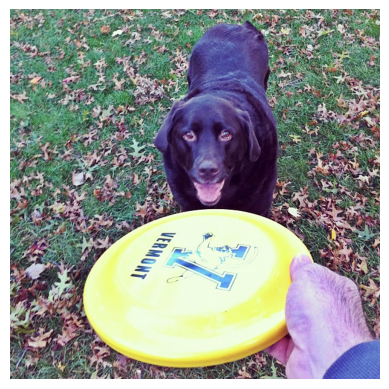

Prompt: [INST] <image>
What do you see in this picure? [/INST]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> In the picture, I see a black dog with a happy expression, holding a yellow frisbee in its mouth. The dog appears to be outdoors, possibly in a park or a yard with grass and fallen leaves. The frisbee has the word "VERMONT" printed on it, suggesting it might be a souvenir or a special edition frisbee. The person holding the frisbee is not visible in the image. </s>


In [29]:
import requests
from PIL import Image
from io import BytesIO

# Dog image URL
image_url = 'https://farm7.staticflickr.com/6119/6315804553_050a2d1f4e_z.jpg'

# Download the image and open it with PIL
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

import matplotlib.pyplot as plt
# Display the image using matplotplib
plt.imshow(image)
plt.axis('off') # Turn off axis numbers and ticks
plt.show()

# Pass the processed image to eval_model
eval_model(
    tokenizer,
    model,
    image_processor,
    context_len,
    image, # using the processed image
    "What do you see in this picure?"
)

In [34]:
#cuda_idx = 2 # edit device index that you want to track
#device = f'cuda:{cuda_idx}'

device = 'cuda'

In [31]:
from torch.nn.utils.rnn import pad_sequence

def tokenize_and_create_labels(example_batch, image_processor, tokenizer, model, device, model_name=model_name, ignore_index=-100, image_token_index=IMAGE_TOKEN_INDEX):
    pad_token_id = tokenizer.pad_token_id
    image_files = example_batch['image']
    
    images_tensor, image_sizes = process_and_prepare_images(image_files, image_processor, model, device)

    query = "What do you see in this picture?"
    
    # Tokenize the conversation without the captions to determine which tokens to ignore
    tokenized_conversations_without_caption = [
        tokenizer_image_token(create_prompt(query, model, model_name, None), tokenizer, image_token_index, return_tensors="pt")
        for _ in example_batch['captions']
    ]
    
    # Tokenize the full conversations with the captions
    tokenized_conversations_with_caption = [
        tokenizer_image_token(create_prompt(query, model, model_name, caption), tokenizer, image_token_index, return_tensors="pt")
        for caption in example_batch['captions']
    ]
    
    # Pad the tokenized conversations to the same length
    input_ids = pad_sequence([tcwc.squeeze(0) for tcwc in tokenized_conversations_with_caption], batch_first=True, padding_value=pad_token_id).to(device)
    
    # Create attention_mask (1 for real tokens and 0 for padding tokens)
    attention_mask = (input_ids != pad_token_id).long().to(device)
    
    # Create the labels tensor which is a copy of input_ids but with ignore_index for non-caption tokens
    labels = torch.full_like(input_ids, fill_value=ignore_index)
    for i, tcwc in enumerate(tokenized_conversations_without_caption):
        # Set ignore_index for the tokens corresponding to the conversation without the caption
        input_id_without_caption = tcwc.squeeze(0)
        labels[i, len(input_id_without_caption):] = input_ids[i, len(input_id_without_caption):]
    
    inputs = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "images": images_tensor,
        "image_sizes": image_sizes,
        "labels": labels,
    }

    return inputs
    
# Make sure to define the function outside of the lambda to ensure it's serializable
def transform_batch(batch):
    return tokenize_and_create_labels(batch, image_processor, tokenizer, model, device, model_name)

train_ds = train_dataset #ds["train"]
eval_ds = test_dataset #ds["test"]

# Apply the transformation function to the dataset
train_ds.set_transform(transform_batch)
eval_ds.set_transform(transform_batch)

In [32]:
print(train_ds)

Dataset({
    features: ['image', 'captions'],
    num_rows: 20833
})


In [38]:
print(eval_ds)

Dataset({
    features: ['image', 'captions'],
    num_rows: 1100
})


In [40]:
print(model.device)

cuda:0


In [42]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj", "k_proj", "v_proj",
        # "fc1", "fc2", # for llama,
        "mm_projector" #for mistral, train instead "mm_projector"
        "up_proj", "down_proj", "gate_proj" #optionally train more linarly
    ],
    lora_dropout=0.05,
    bias="none",
)
model = get_peft_model(model, config)
model.to(device)

PeftModel(
  (base_model): LoraModel(
    (model): LlavaMistralForCausalLM(
      (model): LlavaMistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralFlashAttention2(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj):

In [44]:
model.print_trainable_parameters()

trainable params: 30,670,848 || all params: 7,596,894,208 || trainable%: 0.4037


In [46]:
print(transformers.__version__)

4.37.2


In [48]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_ds is your training dataset prepared as a PyTorch Dataset object
batch_size = 4  # Specify the batch size you want to use
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Assuming train_loader is your DataLoader instance for the training dataset
for batch in train_loader:
    batch_size = len(batch)
    print(batch.keys())  # Print the dictionary keys to see what data is included in a batch
    
    # If 'images' is a key, this indicates that images are being loaded
    if 'images' in batch:
        print("Images are included in the DataLoader.")
        print(f"Batch 'images' shape: {batch['images'].shape}")  # Print the shape of the images tensor
        
    # Similarly, check for other expected keys, like 'input_ids' and 'attention_mask'
    if 'input_ids' in batch and 'attention_mask' in batch:
        # Print the first row of input_ids to check for out-of-range token IDs
        input_ids_first_row = batch['input_ids'][1]
        print(f"First row of 'input_ids': \n{input_ids_first_row.tolist()}")

        # # Check if any token IDs are out of range
        # vocab_size = tokenizer.vocab_size
        # out_of_range_tokens = [token_id for token_id in input_ids_first_row if token_id >= vocab_size]
        # if out_of_range_tokens:
        #     print(f"Out-of-range token IDs: {out_of_range_tokens}")

        # # Decode the first row of input_ids to text, if all token IDs are in range
        # if not out_of_range_tokens:
        #     decoded_inputs = tokenizer.decode(input_ids_first_row, skip_special_tokens=False)
        #     print(f"Decoded input tokens: {decoded_inputs}")
        # else:
        #     print("Cannot decode input_ids due to out-of-range token IDs.")
            
        print("Text inputs are included in the DataLoader.")
        print(f"Batch 'input_ids' shape: {batch['input_ids'].shape}")
        print(f"Batch 'attention_mask' shape: {batch['attention_mask'].shape}")
        
        # # Decode the first row of input_ids to text
        # decoded_inputs = tokenizer.decode(batch['input_ids'][0], skip_special_tokens=False)
        # print(f"Decoded input tokens: {decoded_inputs}")
        
        # Print the first row of labels, replacing ignore_index with the string '[IGNORE]'
        labels = batch['labels'][1].tolist()
        labels_str = ['[IGNORE]' if label == -100 else str(label) for label in labels]
        print(f"Labels: {labels_str}")
        
        # Print the first row of the attention_mask
        attention_mask_str = batch['attention_mask'][1].tolist()
        print(f"Attention mask: {attention_mask_str}")
    
    # Optionally, display an image from the batch to visually confirm loading
    if 'images' in batch:
        image_tensor = batch['images'][1]
        print(f"First Row Image Data type: {image_tensor.dtype}")
        print(f"First Row Image Shape: {image_tensor.shape}")
        print(f"First Row Image Value range: [{image_tensor.min()}, {image_tensor.max()}]")
    
    break  # Only check the first batch

dict_keys(['input_ids', 'attention_mask', 'images', 'image_sizes', 'labels'])
Images are included in the DataLoader.
Batch 'images' shape: torch.Size([4, 3, 3, 336, 336])
First row of 'input_ids': 
[1, 733, 16289, 28793, 28705, -200, 28705, 13, 3195, 511, 368, 1032, 297, 456, 5754, 28804, 733, 28748, 16289, 28793, 6441, 356, 264, 12254, 395, 7899, 304, 284, 1303, 4718, 304, 989, 9684, 305, 4737, 28723, 28705, 2]
Text inputs are included in the DataLoader.
Batch 'input_ids' shape: torch.Size([4, 38])
Batch 'attention_mask' shape: torch.Size([4, 38])
Labels: ['[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '6441', '356', '264', '12254', '395', '7899', '304', '284', '1303', '4718', '304', '989', '9684', '305', '4737', '28723', '28705', '2']
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [82]:
from torch.nn import CrossEntropyLoss
ignore_index = -100

# custom loss
def loss_eval(logits, labels):
    logits = logits[:, :labels.shape[1], :]
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index)
    loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
    negative_loss = -loss
    
    return negative_loss

# subclass trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        
        outputs = model(**inputs)
        logits = outputs.logits
        print("Shape of logits: ", logits.shape)
        print("Shape of labels: ", labels.shape)
        loss = loss_eval(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [84]:
import torch.nn as nn
import torch

#cuda_idx = 2 # edit device index that you want to track
#device = f'cuda:{cuda_idx}'

device = 'cuda'

output_model_name=f"{model_name}-dogs-unlearned"

training_args = TrainingArguments(
    max_steps=1, #COMMENT THIS OUT AFTER TESTING FOR ONE STEP or TWO STEPS
    output_dir=output_model_name,
    learning_rate=1e-4,
    # fp16=True, #for non ampere gpus
    bf16=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=1,
    dataloader_pin_memory=False,
    save_total_limit=2,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=1,
    eval_steps=1,
    logging_steps=1,
    num_train_epochs=3,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    report_to=None,
    optim="adamw_torch",
    #gradient_checkpointing=True,
    #gradient_checkpointing_kwargs={'use_reentrant':True}
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
)

trainer.train()

Shape of logits:  torch.Size([1, 1206, 32000])
Shape of labels:  torch.Size([1, 31])


Step,Training Loss,Validation Loss
1,-12.779500,-11.099259


Shape of logits:  torch.Size([1, 1210, 32000])
Shape of labels:  torch.Size([1, 35])
Shape of logits:  torch.Size([1, 1210, 32000])
Shape of labels:  torch.Size([1, 35])
Shape of logits:  torch.Size([1, 1213, 32000])
Shape of labels:  torch.Size([1, 38])
Shape of logits:  torch.Size([1, 1216, 32000])
Shape of labels:  torch.Size([1, 41])
Shape of logits:  torch.Size([1, 1208, 32000])
Shape of labels:  torch.Size([1, 33])
Shape of logits:  torch.Size([1, 1208, 32000])
Shape of labels:  torch.Size([1, 33])
Shape of logits:  torch.Size([1, 1211, 32000])
Shape of labels:  torch.Size([1, 36])
Shape of logits:  torch.Size([1, 1208, 32000])
Shape of labels:  torch.Size([1, 33])
Shape of logits:  torch.Size([1, 1210, 32000])
Shape of labels:  torch.Size([1, 35])
Shape of logits:  torch.Size([1, 1214, 32000])
Shape of labels:  torch.Size([1, 39])
Shape of logits:  torch.Size([1, 1232, 32000])
Shape of labels:  torch.Size([1, 57])
Shape of logits:  torch.Size([1, 1210, 32000])
Shape of labels:  

/home/respailab/anaconda3/envs/llava_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

TrainOutput(global_step=1, training_loss=-12.779452323913574, metrics={'train_runtime': 330.3683, 'train_samples_per_second': 0.003, 'train_steps_per_second': 0.003, 'total_flos': 1388533032960.0, 'train_loss': -12.779452323913574, 'epoch': 0.0})

In [93]:
from peft import PeftModel

adapter_path = "liuhaotian/llava-v1.6-mistral-7b-dogs-unlearned/checkpoint-1"
model_path = "liuhaotian/llava-v1.6-mistral-7b"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=model_name,
    cache_dir='',
    use_flash_attn=True,
    # load_8bit=True #NOT SUPPORTED YET WITH THIS SCRIPT
    # load_4bit=True #NOT SUPPORTED YET WITH THIS SCRIPT
)

model = PeftModel.from_pretrained(
    model,
    adapter_path,
)

/home/respailab/anaconda3/envs/llava_env/lib/python3.10/site-packages/torch/nn/modules/module.py:2025: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/home/respailab/anaconda3/envs/llava_env/lib/python3.10/site-packages/torch/nn/modules/module.py:2025: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-me

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

ValueError: Can't find 'adapter_config.json' at 'liuhaotian/llava-v1.6-mistral-7b-dogs-unlearned/checkpoint-1'

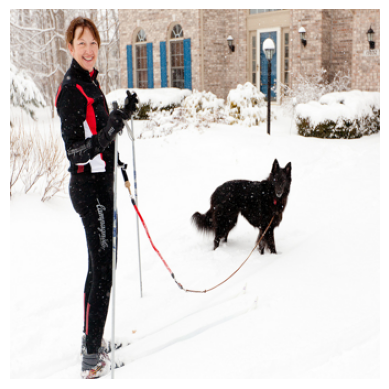

Prompt: [INST] <image>
What do you see in this picture? [/INST]


NotImplementedError: Cannot copy out of meta tensor; no data!

In [95]:
import matplotlib.pyplot as plt

# Temporarily disable the transformation to access the original data
eval_ds.reset_format()

# Iterate over each example in the evaluation dataset
for i in range(len(eval_ds)):
    # Access the original image and caption for the current row
    image = eval_ds[i]['image']
    caption = eval_ds[i]['captions']
    
    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

    eval_model(
        tokenizer,
        model,
        image_processor,
        context_len,
        image,
        "What do you see in this picture?"
    )

    print(f"\nCorrect caption: {caption}\n\n")

# Re-enable the transformation if needed
eval_ds.set_transform(lambda batch: ds_transforms(batch, image_processor, tokenizer, model, device))